#Pasos para crear un modelo VAR con series temporales multivariantes:

1. Análisis exploratorios de los datos.
2. Dividir la serie en conjuntos de entrenamiento y prueba.
3. Prueba de estacionariedad.
4. Transformar la serie de entrenamiento si es necesario. 
5. Construir un modelo VAR sobre las series transformadas.
6. Causalidad de Granger.
7. Diagnóstico del modelo.
8. Realizar pronósticos utilizando el modelo finalmente elegido.
9. Transformación inversa del pronóstico a la escala original.
10. Realizar una evaluación del pronóstico.

# Los datos: 

Conjunto de datos de sensores de gas expuestos a mezclas de gases turbulentos.

Una plataforma de detección química compuesta por 8 sensores de gas quimio-resistivos se expuso a una mezcla de gases turbulentos generada naturalmente en un túnel de viento. Se proporcionan las series de tiempo adquiridas de los sensores.

Originalmente obtenidos del repositorio UCI Machine Learning:

https://archive.ics.uci.edu/ml/datasets/Gas+sensor+array+exposed+to+turbulent+gas+mixtures

In [1]:
import pandas as pd
df_comp = pd.read_csv("Sensores.csv")
df_comp.head()

,Time,Temperature,Rel_Humidity,S1,S2,S3,S4,S5,S6,S7,S8
0,3.0,20.94,35.98,312,280,504,568,528,647,578,664
1,3.1,20.94,35.98,310,280,504,568,527,647,578,664
2,3.2,20.94,35.98,311,280,503,567,528,648,577,664
3,3.3,20.94,35.98,310,280,503,567,527,648,578,665
4,3.4,20.94,35.98,311,280,503,568,528,647,577,664


In [2]:
# Eliminar la variable Time
df_comp = df_comp.drop(['Time'], axis = 1)

In [3]:
df_comp.head()

,Temperature,Rel_Humidity,S1,S2,S3,S4,S5,S6,S7,S8
0,20.94,35.98,312,280,504,568,528,647,578,664
1,20.94,35.98,310,280,504,568,527,647,578,664
2,20.94,35.98,311,280,503,567,528,648,577,664
3,20.94,35.98,310,280,503,567,527,648,578,665
4,20.94,35.98,311,280,503,568,528,647,577,664


In [4]:
df_comp.isnull().sum()

Temperature     0
Rel_Humidity    0
S1              0
S2              0
S3              0
S4              0
S5              0
S6              0
S7              0
S8              0
dtype: int64

# Análisis exploratorio

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


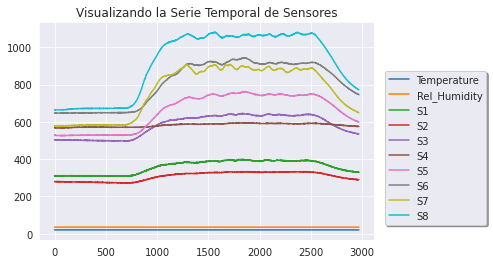

In [5]:
# Visualizando los datos
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style('darkgrid')
df_comp.plot(kind = 'line', legend = 'reverse', title = 'Visualizando la Serie Temporal de Sensores')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

Las variables Temperatura y Humedad Relativa no cambian con el tiempo, no van a aportar nada, vamos a eliminarlas.

In [6]:
# Eliminando Temperature & Relative Humidity 
df_comp.drop(['Temperature','Rel_Humidity'], axis = 1, inplace = True)
df_comp.head()

,S1,S2,S3,S4,S5,S6,S7,S8
0,312,280,504,568,528,647,578,664
1,310,280,504,568,527,647,578,664
2,311,280,503,567,528,648,577,664
3,310,280,503,567,527,648,578,665
4,311,280,503,568,528,647,577,664


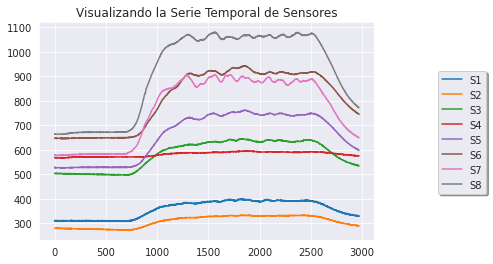

In [7]:
# Visualizando de nuevo
sb.set_style('darkgrid')
df_comp.plot(kind = 'line', legend = 'reverse', title = 'Visualizando la Serie Temporal de Sensores')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

In [8]:
corr=df_comp.corr()
corr

,S1,S2,S3,S4,S5,S6,S7,S8
S1,1.000000,0.995193,0.999181,0.972182,0.990123,0.983514,0.993030,0.992362
S2,0.995193,1.000000,0.996795,0.979123,0.994925,0.990738,0.982652,0.985165
S3,0.999181,0.996795,1.000000,0.974502,0.992848,0.986778,0.992203,0.993107
S4,0.972182,0.979123,0.974502,1.000000,0.987546,0.987288,0.951431,0.954937
S5,0.990123,0.994925,0.992848,0.987546,1.000000,0.998523,0.979379,0.983379
S6,0.983514,0.990738,0.986778,0.987288,0.998523,1.000000,0.971165,0.975541
S7,0.993030,0.982652,0.992203,0.951431,0.979379,0.971165,1.000000,0.997709
S8,0.992362,0.985165,0.993107,0.954937,0.983379,0.975541,0.997709,1.000000


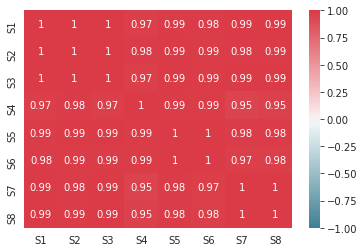

In [9]:
sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0 )
plt.show()

# Dividir los datos en conjunto de Entrenamiento y Prueba
El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

In [10]:
n_obs=100
X_train, X_test = df_comp[0:-n_obs], df_comp[-n_obs:]
print(X_train.shape, X_test.shape)

(2870, 8) (100, 8)


# Prueba de estacionariedad
Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [11]:
import statsmodels.tsa.stattools as sts

In [12]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(8):
  print('Serie de tiempo Sensor', 'S',i+1)
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])


Test de Dickey-Fuller Aumentado:
Serie de tiempo Sensor S 1
p-value: 0.635726
Serie de tiempo Sensor S 2
p-value: 0.591206
Serie de tiempo Sensor S 3
p-value: 0.442536
Serie de tiempo Sensor S 4
p-value: 0.395935
Serie de tiempo Sensor S 5
p-value: 0.342279
Serie de tiempo Sensor S 6
p-value: 0.392289
Serie de tiempo Sensor S 7
p-value: 0.628354
Serie de tiempo Sensor S 8
p-value: 0.399947


Todos los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

# Transformación de los datos
La aplicación de la primera diferenciación en el conjunto de entrenamiento debería hacer que todas las series 6 sean estacionarias. Sin embargo, este es un proceso iterativo en el que, después de la primera diferenciación, es posible que la serie siga siendo no estacionaria. Tendremos que aplicar una segunda diferencia o transformación logarítmica para estandarizar la serie en tales casos.

In [13]:
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,S1,S2,S3,S4,S5,S6,S7,S8
1,-2.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,1.0,0.0,-1.0,-1.0,1.0,1.0,-1.0,0.0
3,-1.0,0.0,0.0,0.0,-1.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-1.0
5,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


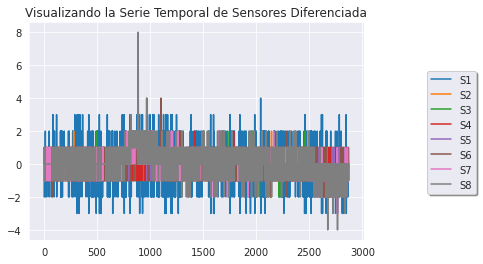

In [14]:
sb.set_style('darkgrid')
X_train_transformed.plot(kind = 'line', legend = 'reverse', title = 'Visualizando la Serie Temporal de Sensores Diferenciada')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

Chequeando si los datos transformados (diferenciados) son estacionarios:

In [15]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(8):
  print('Serie de tiempo transformada Sensor', 'S',i+1)
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Sensor S 1
p-value: 0.002478
Serie de tiempo transformada Sensor S 2
p-value: 0.026087
Serie de tiempo transformada Sensor S 3
p-value: 0.117335
Serie de tiempo transformada Sensor S 4
p-value: 0.000004
Serie de tiempo transformada Sensor S 5
p-value: 0.356708
Serie de tiempo transformada Sensor S 6
p-value: 0.330315
Serie de tiempo transformada Sensor S 7
p-value: 0.000021
Serie de tiempo transformada Sensor S 8
p-value: 0.151425


S3, S5, S6 y S8 aún no son estacionarias

In [16]:
#Diferenciando por segunda vez
X_train_transformed=X_train_transformed.diff().dropna()
X_train_transformed.head()

,S1,S2,S3,S4,S5,S6,S7,S8
2,3.0,0.0,-1.0,-1.0,2.0,1.0,-1.0,0.0
3,-2.0,0.0,1.0,1.0,-2.0,-1.0,2.0,1.0
4,2.0,0.0,0.0,1.0,2.0,-1.0,-2.0,-2.0
5,-2.0,0.0,1.0,-1.0,-1.0,1.0,1.0,1.0
6,1.0,0.0,-2.0,0.0,0.0,0.0,1.0,0.0


In [17]:
print('Test de Dickey-Fuller Aumentado 3ra vez:')
for i in range(8):
  print('Serie de tiempo transformada Sensor', 'S',i+1)
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 3ra vez:
Serie de tiempo transformada Sensor S 1
p-value: 0.000000
Serie de tiempo transformada Sensor S 2
p-value: 0.000000
Serie de tiempo transformada Sensor S 3
p-value: 0.000000
Serie de tiempo transformada Sensor S 4
p-value: 0.000000
Serie de tiempo transformada Sensor S 5
p-value: 0.000000
Serie de tiempo transformada Sensor S 6
p-value: 0.000000
Serie de tiempo transformada Sensor S 7
p-value: 0.000000
Serie de tiempo transformada Sensor S 8
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con un solo orden de diferenciación se obtienen series estacionarias.

# Modelo VAR
VAR requiere la estacionariedad de la serie, lo que significa que la media de la serie no cambia con el tiempo (podemos verlo en el gráfico dibujado junto a la Prueba de Dickey-Fuller aumentada).

In [18]:
from statsmodels.tsa.api import VAR

In [19]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Seleccionando el orden del modelo

In [20]:
modelsel=model.select_order(15)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,1.386,1.402,3.998,1.392
1,-3.107,-2.956,0.04475,-3.053
2,-5.367,-5.083,0.004667,-5.265
3,-6.730,-6.313,0.001194,-6.580
4,-7.566,-7.015,0.0005179,-7.367
5,-8.147,-7.463,0.0002895,-7.900
6,-8.524,-7.705,0.0001987,-8.229
7,-8.874,-7.922,0.0001400,-8.531
8,-9.116,-8.031,0.0001099,-8.725
9,-9.308,-8.089,9.072e-05,-8.868


## Ajustando el modelo

In [21]:
res = model.fit(maxlags=15, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Sep, 2020
Time:                     09:57:12
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -7.81811
Nobs:                     2853.00    HQIC:                  -9.11022
Log likelihood:          -17382.6    FPE:                5.33536e-05
AIC:                     -9.83898    Det(Omega_mle):     3.82692e-05
--------------------------------------------------------------------
Results for equation S1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.000144         0.015731           -0.009           0.993
L1.S1         -1.732086         0.019154          -90.429           0.000
L1.S2         -0.015932         0.033596           -0.474           0.635
L1.S3         -0.

# Causalidad de Granger

In [22]:
grangercaus=res.test_causality(['S2','S3','S4','S5','S6','S7','S8'],['S1'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.237,1.238,0.051,"(105, 21856)"


In [23]:
grangercaus=res.test_causality(['S1','S3','S4','S5','S6','S7','S8'],['S2'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9224,1.238,0.702,"(105, 21856)"


In [24]:
grangercaus=res.test_causality(['S2','S1','S4','S5','S6','S7','S8'],['S3'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.9690,1.238,0.572,"(105, 21856)"


In [25]:
grangercaus=res.test_causality(['S2','S3','S1','S5','S6','S7','S8'],['S4'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.175,1.238,0.107,"(105, 21856)"


In [26]:
grangercaus=res.test_causality(['S2','S3','S4','S1','S6','S7','S8'],['S5'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.574,1.238,0.000,"(105, 21856)"


In [27]:
grangercaus=res.test_causality(['S2','S3','S4','S5','S1','S7','S8'],['S6'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.493,1.238,0.001,"(105, 21856)"


In [28]:
grangercaus=res.test_causality(['S2','S3','S4','S5','S6','S1','S8'],['S7'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.034,1.238,0.000,"(105, 21856)"


In [29]:
grangercaus=res.test_causality(['S2','S3','S4','S5','S6','S7','S1'],['S8'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.576,1.238,0.000,"(105, 21856)"


Conclusión: 
Sensores que no son causa:  S1, S2, S3, S4

# Matriz de causalidad de Granger

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)


,S1_x,S2_x,S3_x,S4_x,S5_x,S6_x,S7_x,S8_x
S1_y,1.0000,0.0710,0.2540,0.1281,0.0063,0.0702,0.0269,0.0009
S2_y,0.0153,1.0000,0.0768,0.0019,0.3979,0.0358,0.0634,0.2109
S3_y,0.0271,0.5224,1.0000,0.0196,0.0000,0.0006,0.0039,0.5624
S4_y,0.0319,0.0057,0.3067,1.0000,0.0056,0.0167,0.1431,0.1023
S5_y,0.0916,0.7043,0.0196,0.0146,1.0000,0.0005,0.0068,0.0151
S6_y,0.1878,0.0334,0.0470,0.0789,0.0070,1.0000,0.0000,0.0000
S7_y,0.1663,0.3981,0.0842,0.3431,0.0599,0.0003,1.0000,0.0000
S8_y,0.0182,0.3024,0.1306,0.0004,0.0223,0.0008,0.0000,1.0000


# Diagnosis del modelo

## Residuos

In [31]:
residuals=res.resid

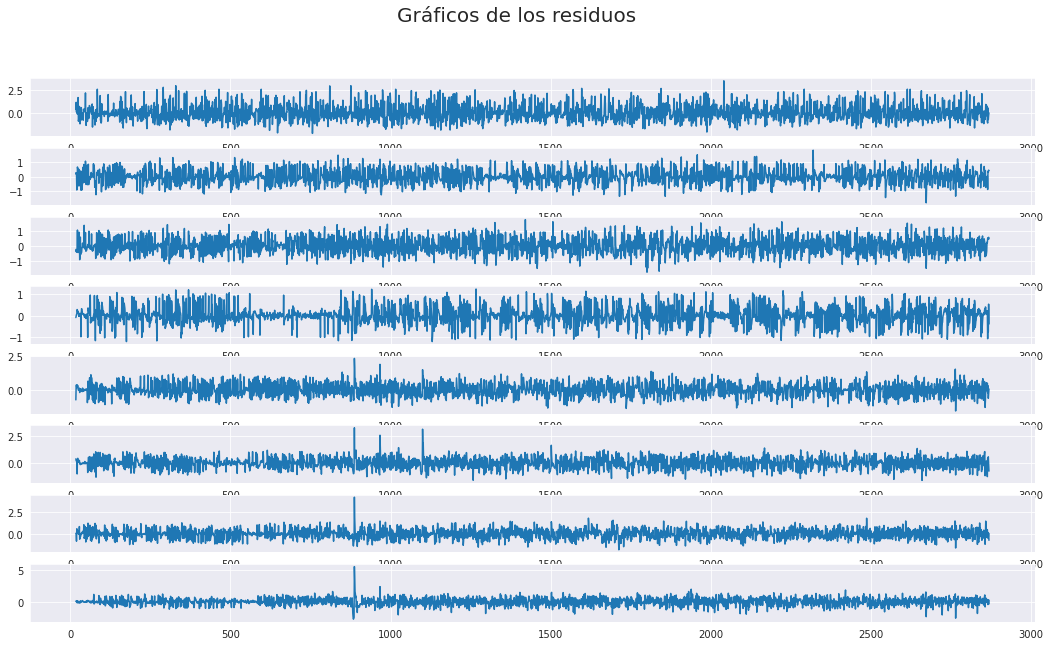

In [32]:
fig, axs = plt.subplots(8)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(8)]
plt.show()

## Dickey - Fuller a los residuos

In [33]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(8)]


ADF de los Residuos, p-valores:


[1.637207008729251e-26,
 3.4631550793697566e-29,
 3.539849937644814e-27,
 2.4895627135221888e-30,
 2.075671326715412e-30,
 0.0,
 0.0,
 0.0]

Todos los p-valores son < 0.05 por tanto se rechaza la hipótesis nula de que las 6 series de residuos no son estacionarias, por lo cual con un 95% de confianza se cree que son estacionarias. 

## ACF de los Residuos

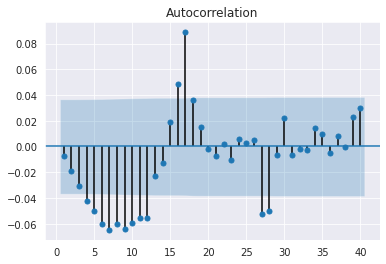

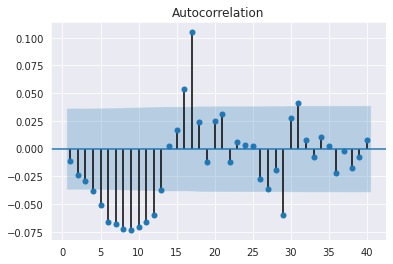

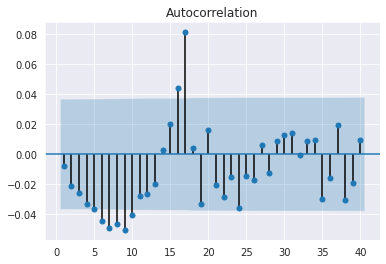

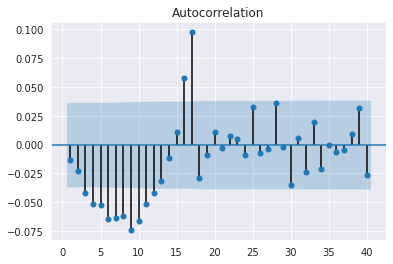

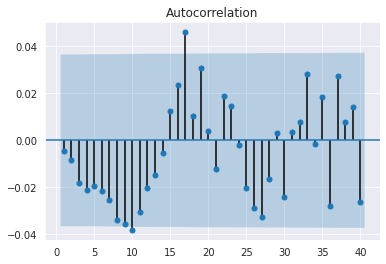

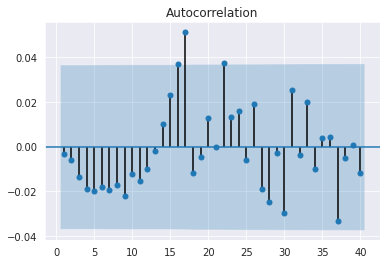

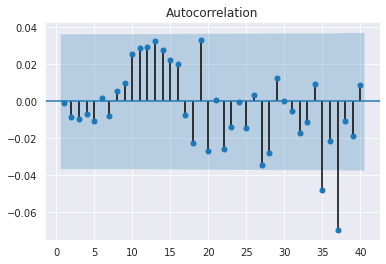

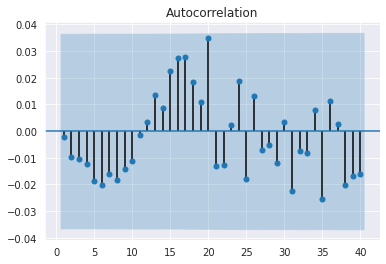

In [34]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in range(8)]
plt.show()


Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.

## Valores predichos

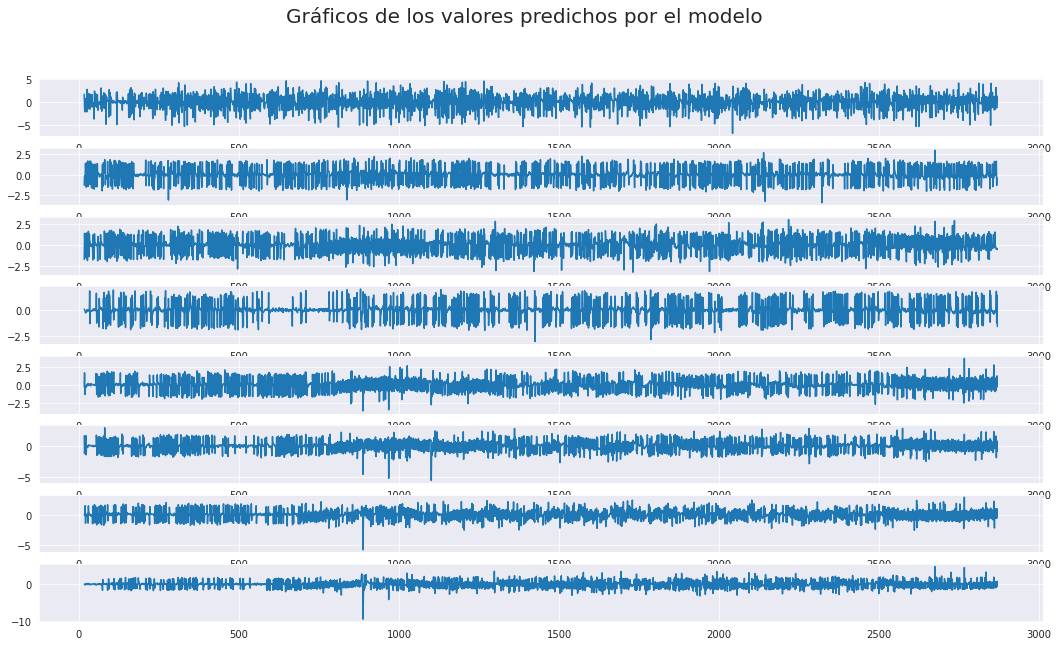

In [35]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(8)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(8)]
plt.show()

# Pronósticos a futuro

## Hallando los pronósticos

Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.


In [37]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 15
Predicciones:


,S1_pred,S2_pred,S3_pred,S4_pred,S5_pred,S6_pred,S7_pred,S8_pred
2870,-0.151708,-0.348981,-0.742243,1.476815e+00,-0.532157,0.837154,1.036561,-0.821517
2871,0.274310,0.264058,0.719858,-4.947983e-01,0.037031,-0.279372,-0.519520,0.220567
2872,-0.338914,-0.181531,-0.104239,-1.688083e-02,0.121353,-0.159702,-0.165005,-0.042070
2873,0.089755,0.397819,0.078693,-1.527574e-01,0.009346,0.115261,0.264931,-0.021685
2874,-0.114020,-0.314505,-0.110712,-3.086360e-03,0.114080,-0.076102,-0.109191,0.128296
...,...,...,...,...,...,...,...,...
2965,-0.000022,0.000002,-0.000047,3.466898e-06,-0.000111,-0.000149,-0.000133,-0.000205
2966,-0.000048,-0.000004,-0.000048,2.975732e-06,-0.000103,-0.000159,-0.000135,-0.000196
2967,-0.000061,-0.000014,-0.000033,-2.564654e-06,-0.000101,-0.000156,-0.000137,-0.000204
2968,-0.000039,-0.000020,-0.000043,5.708600e-07,-0.000110,-0.000149,-0.000144,-0.000209


<Figure size 864x720 with 0 Axes>

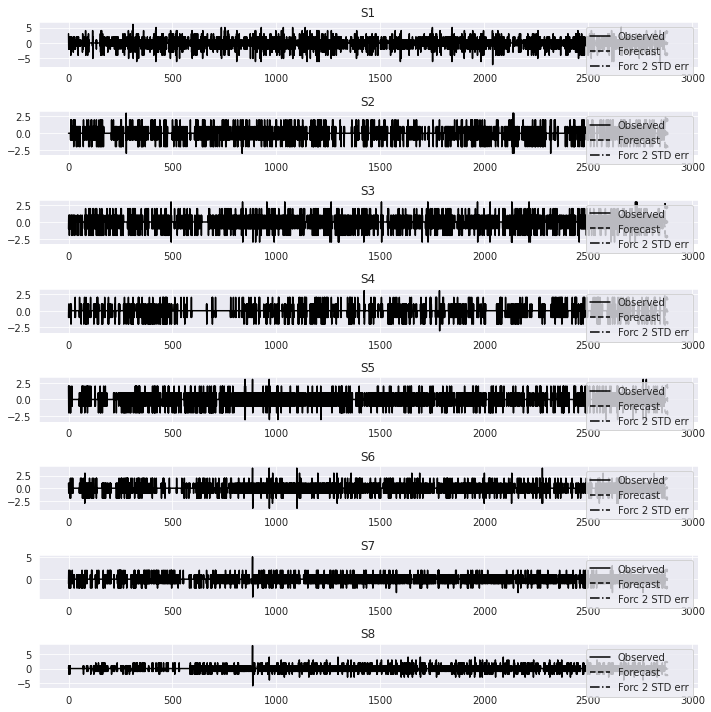

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

## Invirtiendo la transformación de los pronósticos a la escala original

Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos.
La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base.
Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [39]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [40]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,S1,S2,S3,S4,S5,S6,S7,S8
2870,335.848292,295.651019,547.257757,578.476815,624.467843,776.837154,678.036561,814.178483
2871,335.970894,295.566097,547.235372,578.458832,623.972716,776.394935,677.553602,813.577534
2872,335.754582,295.299644,547.108747,578.423967,623.598943,775.793015,676.905638,812.934515
2873,335.628024,295.431010,547.060815,578.236346,623.234516,775.306355,676.522606,812.269811
2874,335.387447,295.247870,546.902171,578.045638,622.984168,774.743594,676.030383,811.733403
...,...,...,...,...,...,...,...,...
2965,321.597466,289.986169,536.336793,572.682841,589.775571,726.375873,632.801934,756.121125
2966,321.445289,289.926379,536.217549,572.622822,589.406340,725.836878,632.319990,755.501087
2967,321.293052,289.866574,536.098272,572.562800,589.037008,725.297726,631.837908,754.880845
2968,321.140775,289.806749,535.978953,572.502779,588.667567,724.758426,631.355684,754.260394


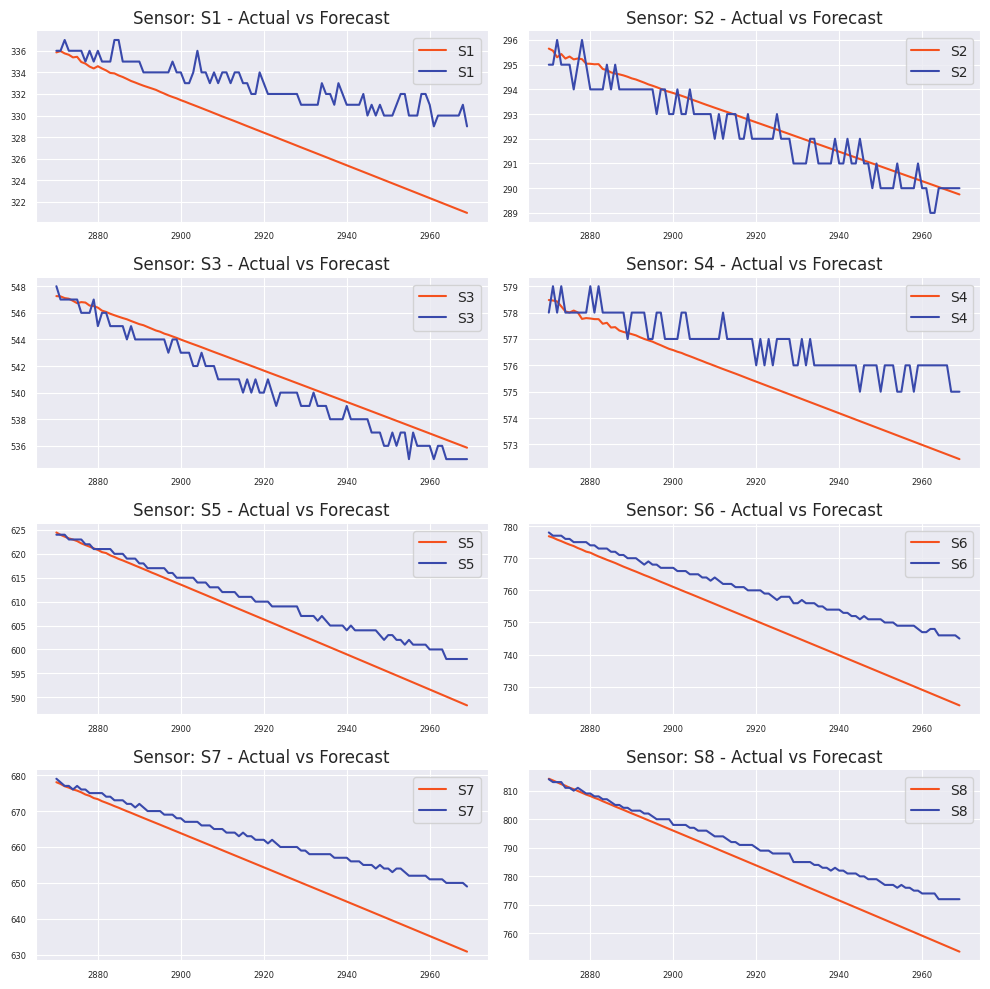

In [41]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Sensor: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()


# Evaluando el modelo

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 4.5370024238929725
Root mean squared error: 6.689114236330293


# Eliminando las variables S1, S2, S3, S4

In [43]:
X_train_transformed_new=X_train_transformed.drop(['S1','S2','S3','S4'],axis=1)
X_train_transformed_new.head()

,S5,S6,S7,S8
2,2.0,1.0,-1.0,0.0
3,-2.0,-1.0,2.0,1.0
4,2.0,-1.0,-2.0,-2.0
5,-1.0,1.0,1.0,1.0
6,0.0,0.0,1.0,0.0


## Modelo VAR

In [44]:
model_new = VAR(X_train_transformed_new)

In [45]:
modelsel_new=model_new.select_order(15)
modelsel_new.summary()

,AIC,BIC,FPE,HQIC
0,0.2114,0.2198,1.235,0.2145
1,-1.989,-1.947,0.1368,-1.974
2,-3.139,-3.064,0.04332,-3.112
3,-3.781,-3.673,0.02280,-3.742
4,-4.201,-4.059,0.01498,-4.150
5,-4.462,-4.287,0.01154,-4.399
6,-4.639,-4.430,0.009669,-4.564
7,-4.809,-4.567,0.008158,-4.721
8,-4.918,-4.643,0.007312,-4.819
9,-5.012,-4.703,0.006656,-4.901


## Ajustando el modelo

In [46]:
res_new = model_new.fit(maxlags=15, ic='aic')
res_new.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Sep, 2020
Time:                     10:03:22
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -4.69025
Nobs:                     2853.00    HQIC:                  -5.01595
Log likelihood:          -8531.63    FPE:                 0.00551866
AIC:                     -5.19965    Det(Omega_mle):      0.00507087
--------------------------------------------------------------------
Results for equation S5
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.001518         0.008984           -0.169           0.866
L1.S5         -1.680205         0.019086          -88.032           0.000
L1.S6          0.047984         0.018224            2.633           0.008
L1.S7          0.

## Causalidad de Granger

In [47]:
grangercaus=res_new.test_causality(['S6','S7','S8'],['S5'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.125,1.371,0.262,"(45, 11168)"


In [48]:
grangercaus=res_new.test_causality(['S5','S7','S8'],['S6'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.663,1.371,0.004,"(45, 11168)"


In [49]:
grangercaus=res_new.test_causality(['S5','S6','S8'],['S7'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.984,1.371,0.000,"(45, 11168)"


In [50]:
grangercaus=res_new.test_causality(['S5','S6','S7'],['S8'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.304,1.371,0.000,"(45, 11168)"


Conclusión: 
Sensores que no son causa:  S5

In [51]:
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed_new, variables = X_train_transformed_new.columns)

,S5_x,S6_x,S7_x,S8_x
S5_y,1.0000,0.0005,0.0068,0.0151
S6_y,0.0070,1.0000,0.0000,0.0000
S7_y,0.0599,0.0003,1.0000,0.0000
S8_y,0.0223,0.0008,0.0000,1.0000


## Hallando los pronósticos

In [52]:
X_test_new=X_test.drop(['S1','S2','S3','S4'],axis=1)
X_test_new.head()

,S5,S6,S7,S8
2870,624,778,679,814
2871,624,777,678,813
2872,624,777,677,813
2873,623,777,677,813
2874,623,776,676,811


In [53]:
# Obtener el orden del modelo
lag_order = res_new.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed_new.values[-lag_order:]
# Forecasting
pred_new = res_new.forecast(y=input_data, steps=n_obs)
pred_new = (pd.DataFrame(pred_new, index=X_test_new.index, columns=X_test_new.columns + '_pred'))
print('Predicciones:')
pred_new

Orden del modelo: 15
Predicciones:


,S5_pred,S6_pred,S7_pred,S8_pred
2870,-0.471167,0.786053,1.076164,-0.812804
2871,-0.039449,-0.255304,-0.571279,0.214358
2872,0.202670,-0.132170,-0.134030,-0.086874
2873,0.006603,0.140829,0.216278,0.035383
2874,-0.014477,-0.110470,-0.195531,0.059118
...,...,...,...,...
2965,-0.000097,-0.000157,-0.000144,-0.000197
2966,-0.000097,-0.000158,-0.000145,-0.000197
2967,-0.000098,-0.000158,-0.000145,-0.000197
2968,-0.000097,-0.000158,-0.000145,-0.000197


## Invirtiendo la transformación de los pronósticos a la escala original

In [54]:
X_train_new=X_train.drop(['S1','S2','S3','S4'],axis=1)

In [55]:
pred_new.columns=X_test_new.columns
output = invert_transformation(X_train_new, pred_new, second_diff=True)
output

,S5,S6,S7,S8
2870,624.528833,776.786053,678.076164,814.187196
2871,624.018217,776.316802,677.581049,813.588750
2872,623.710271,775.715381,676.951904,812.903430
2873,623.408927,775.254789,676.539038,812.253494
2874,623.093107,774.683728,675.930641,811.662674
...,...,...,...,...
2965,590.738942,725.811311,631.851609,755.969373
2966,590.379387,725.266735,631.359332,755.347724
2967,590.019735,724.722002,630.866909,754.725878
2968,589.659985,724.177110,630.374342,754.103835


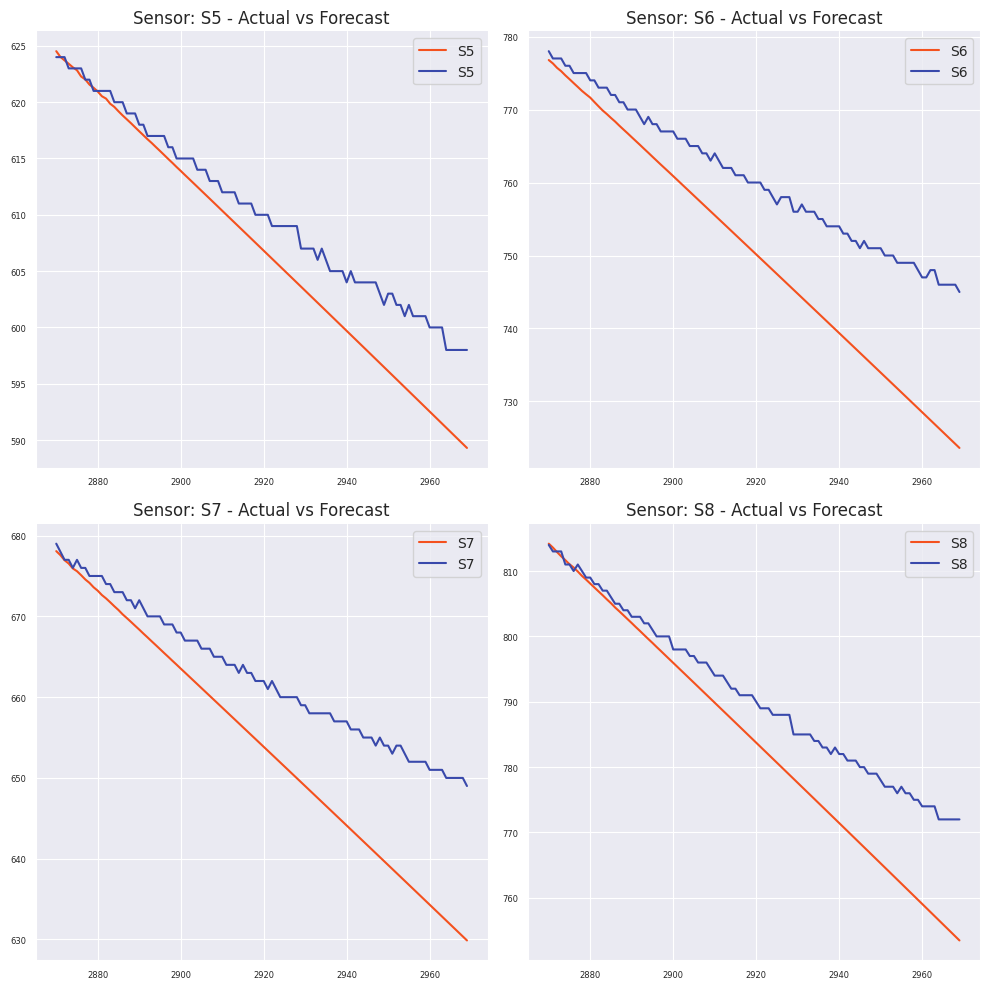

In [56]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train_new.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col,ax) in enumerate(zip(X_train_new.columns, axes.flatten())):
    output[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test_new[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Sensor: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()


## Evaluando el modelo

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test_new, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test_new, output)))

Mean absolute error: 7.3264799375699186
Root mean squared error: 9.267816945140602


Métricas anteriores:

Mean absolute error: 4.5370024238929725

Root mean squared error: 6.689114236330293

Conclusión: No siempre eliminar de golpe varias variables es la mejor solución.